**Soccer Coaches Performance Analysis By Evaluated** **Tweets**

[Research Paper](https://)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install snscrape
!pip install ProfanityDetector
!pip install pandas
!pip install nltk
!pip install -U sentence-transformers
!pip install sklearn
!pip install numpy
!pip install transformers[sentencepiece]
!pip install matplotlib
!pip install tweetnlp
!pip install spacy
!pip install keybert
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 KB 8.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.0 M

In [ ]:
import snscrape.modules.twitter as sntwitter
from ProfanityDetector import detector
import pandas as pd
import os
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import math
import tweetnlp
import spacy
from keybert import KeyBERT
import networkx as nx
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import random
from sklearn import metrics

In [ ]:
# Task no.1: Data extraction and twitter crawling

queries = ["de zerbi lang:en since:2022-09-20 until:2022-11-25", "de zerbi lang:en since:2022-12-26 until:2023-03-04"]
for query in queries:
    tweets = []
    limit = 50000
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        if(len(tweets) > limit):
            break
        else:
            tweets.append(tweet.content)
    tweets = list(dict.fromkeys(tweetsFile["Tweet"].tolist()))
    df = pd.DataFrame({'Tweet': tweets})
    df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/crawled/{query}.csv", index=False)

In [ ]:
# Task no.2: Preprocessing the crawled tweets

files = os.listdir('/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/crawled')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
tk = TweetTokenizer()
stopwordsList = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB     
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
def finalPreprocess(tweet):
    tweet = re.sub(r'[^\w\s]',' ', tweet)
    tweet = re.sub(r'[^a-zA-Z0-9 ]', ' ', tweet);
    tweet = tweet.lower()
    tweet = [token for token in tk.tokenize(tweet) if not token in stopwordsList]
    tweet = " ".join(tweet)
    preprocessedTweet = []
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(str(tweet)))
    wordnet_tagged = [*map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged)]
    preprocessedTweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            preprocessedTweet.append(word)
        else:
            preprocessedTweet.append(lemmatizer.lemmatize(word, tag))
    preprocessedTweet = " ".join(preprocessedTweet)
    return preprocessedTweet
def primitivePreprocess(tweet):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u'\U00010000-\U0010ffff'
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
    "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', ' ', tweet)
    tweet = re.sub(r"#([a-zA-Z0-9_]{1,50})", ' ', tweet)
    tweet = re.sub(r"@([a-zA-Z0-9_]{1,50})", ' ', tweet)
    tweet = re.sub(r"&([a-zA-Z0-9_]{1,50})", ' ', tweet)
    return tweet
for file in files:
    primitivePreprocessedTweets = []
    finalPreprocessedTweets = []
    tweetsFile = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/crawled/{file}")
    tweets = tweetsFile["Tweet"].tolist()
    for tweet in tweets:
        tweet = primitivePreprocess(tweet)
        if tweet.lower().find('de zerbi') != -1 and detector(tweet)[1] == False:
            primitivePreprocessedTweets.append(tweet)
    primitivePreprocessedTweets = list(dict.fromkeys(primitivePreprocessedTweets))
    for tweet in primitivePreProcessedTweets:
        finalPreprocessedTweets.append(finalPreprocess(tweet))
    finalPreprocessedTweets = [(" ".join([token.text_with_ws for token in nlp(tweet) if token.pos_ == "NOUN" or token.pos_ == "VERB" or token.pos_ == "PROPN" or token.pos_ == "ADJ"])) for tweet in finalPreprocessedTweets if isinstance(tweet, str)]
    df = pd.DataFrame({"Tweet": primitivePreprocessedTweets, "Preprocessed": finalPreprocessedTweets})
    df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/preprocessed/{file}", index=False)

KNN Confusion Matrix:


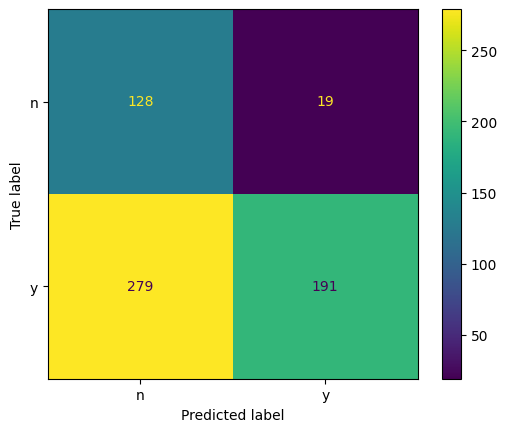

Length of KNN Noisy Predictions: 2509
RFC Confusion Matrix 1:


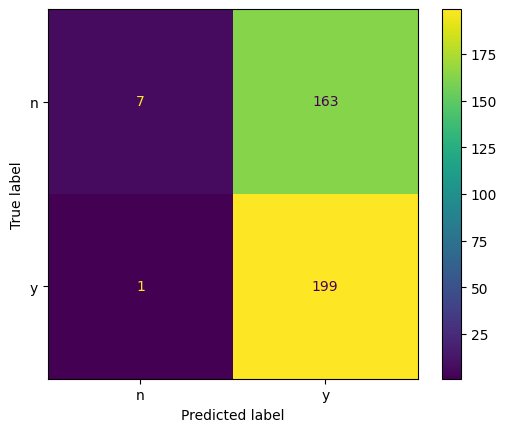

RFC Confusion Matrix 2:


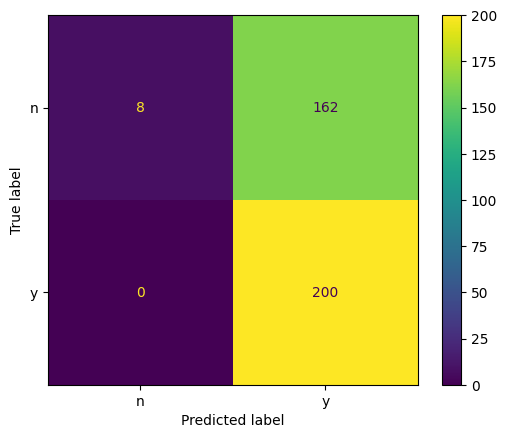

RFC Confusion Matrix 3:


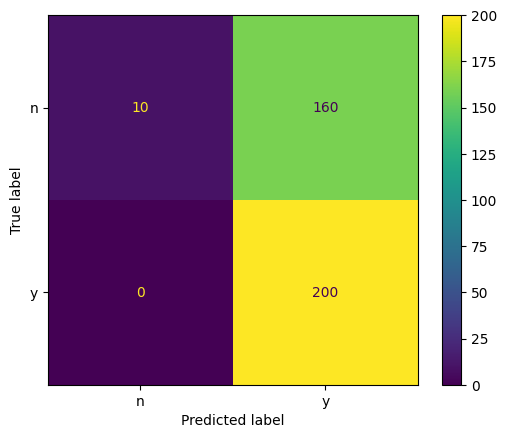

RFC Confusion Matrix 4:


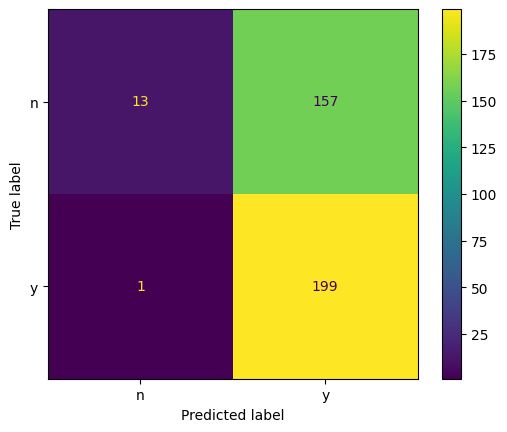

RFC Confusion Matrix 5:


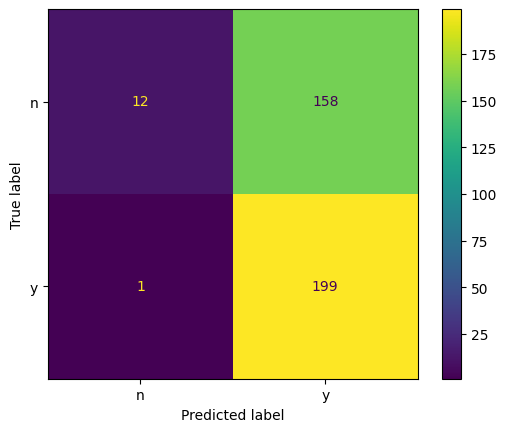

RFC Confusion Matrix 6:


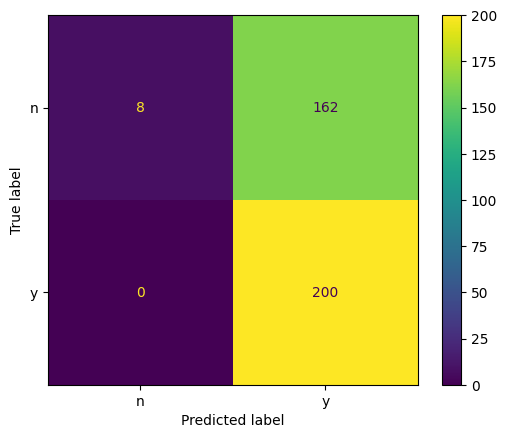

RFC Confusion Matrix 7:


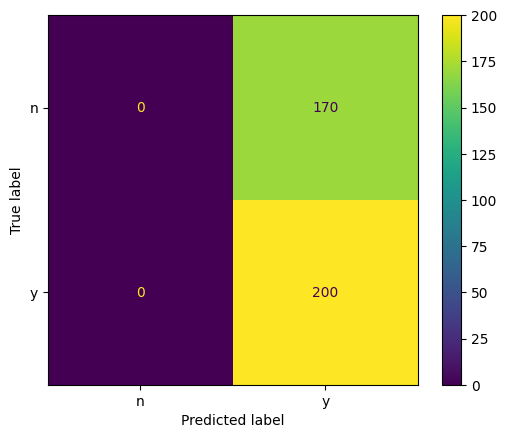

RFC Confusion Matrix (By Being Trained Under All Gained Data):


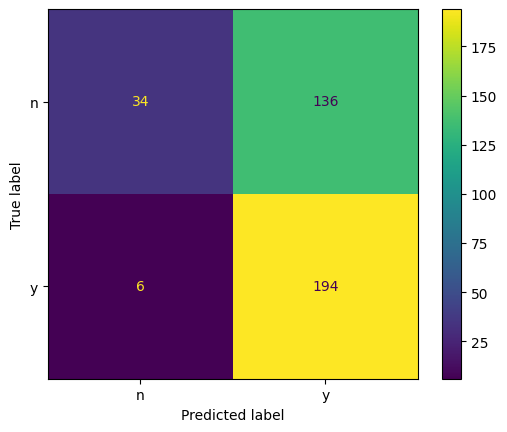

Length of RFC Useful Predictions: 1084


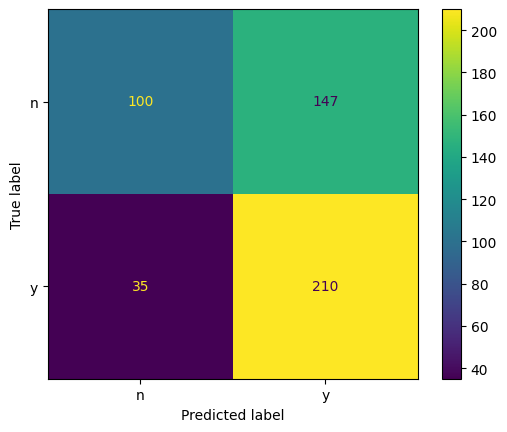

Length of MLP Useful Predictions: 841


In [ ]:
# Task no.3: Filtering useful tweets out of noisy ones

model = SentenceTransformer('all-MiniLM-L6-v2')
knn = KNeighborsClassifier(n_neighbors=2)
handyLabelledMain = []
handyLabelledPreprocessed = []
handyLabelledFeature = []
handyLabelledNoisy = []
knnNutrimentMain = []
knnNutrimentPreprocessed = []
knnNutrimentFeature = []
tweetsFile = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/de zerbi.csv")
for index, row in tweetsFile.iterrows():
    if row["Noisy"] == "y" or row["Noisy"] == "n":
        handyLabelledMain.append(row["Tweet"])
        handyLabelledPreprocessed.append(row["Preprocessed"])
        handyLabelledNoisy.append(row["Noisy"])
    else:
        knnNutrimentMain.append(row["Tweet"])
        knnNutrimentPreprocessed.append(row["Preprocessed"])
for tweet in handyLabelledPreprocessed:
    vector = model.encode(tweet)
    handyLabelledFeature.append(vector)
for tweet in knnNutrimentPreprocessed:
    vector = model.encode(tweet)
    knnNutrimentFeature.append(vector)
knnNutrimentFeature = np.array([feature.tolist() for feature in knnNutrimentFeature])
handyNMain = []
handyNPreprocessed = []
handyNFeature = []
handyYMain = []
handyYFeature = []
handyYPreprocessed = []
for i in range(len(handyLabelledNoisy)):
    if handyLabelledNoisy[i] == "n":
        handyNFeature.append(handyLabelledFeature[i])
        handyNMain.append(handyLabelledMain[i])
        handyNPreprocessed.append(handyLabelledPreprocessed[i])
    elif handyLabelledNoisy[i] == "y":
        handyYFeature.append(handyLabelledFeature[i])
        handyYMain.append(handyLabelledMain[i])
        handyYPreprocessed.append(handyLabelledPreprocessed[i])
random.seed(3)
random.shuffle(handyNFeature)
random.shuffle(handyYFeature)
x_train = handyYFeature[:175] + handyNFeature[:250]
x_test = handyYFeature[175:] + handyNFeature[250:]
label_train = 175*["y"] + 250*["n"]
label_test = len(handyYFeature[175:]) * ["y"] + len(handyNFeature[250:])*["n"]
knn.fit(x_train, label_train)
confusion_matrix = metrics.confusion_matrix(label_test, knn.predict(x_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['n', 'y'])
print("KNN Confusion Matrix:")
cm_display.plot()
plt.show()
predictions = knn.predict(knnNutrimentFeature)
knnYPredictsMain = []
knnYPredictsPreprocessed = []
knnNPredictsMain = []
knnNPredictsPreprocessed = []
c = 0
for i in range(len(predictions)):
    if predictions[i] == "y":
        c = c + 1
        knnYPredictsMain.append(knnNutrimentMain[i])
        knnYPredictsPreprocessed.append(knnNutrimentPreprocessed[i])
    else:
        knnNPredictsMain.append(knnNutrimentMain[i])
        knnNPredictsPreprocessed.append(knnNutrimentPreprocessed[i])
print(f"Length of KNN Noisy Predictions: {c}")
length = 0
j = 0
nMainSaver = []
nPreprocessedSaver = []
mainSaver = []
preprocessedSaver = []
noisySaver = []
rfcTestingLabels = []
mixHandyKnnYMain = knnYPredictsMain + handyYMain
mixHandyKnnYPreprocessed = knnYPredictsPreprocessed + handyYPreprocessed
shuffleHandyNMain = handyNMain
shuffleHandyNPreprocessed = handyNPreprocessed
random.seed(3)
temp1 = list(zip(mixHandyKnnYMain, mixHandyKnnYPreprocessed))
temp2 = list(zip(shuffleHandyNMain, shuffleHandyNPreprocessed))
random.shuffle(temp1)
random.shuffle(temp2)
mixHandyKnnYMain, mixHandyKnnYPreprocessed = zip(*temp1)
shuffleHandyNMain, shuffleHandyNPreprocessed = zip(*temp2)
mixHandyKnnYMain, mixHandyKnnYPreprocessed = list(mixHandyKnnYMain), list(mixHandyKnnYPreprocessed)
shuffleHandyNMain, shuffleHandyNPreprocessed = list(shuffleHandyNMain), list(shuffleHandyNPreprocessed)
firstTrainerPreprocessed = shuffleHandyNPreprocessed[:220] + mixHandyKnnYPreprocessed[:450]
firstTrainerMain = shuffleHandyNMain[:220] + mixHandyKnnYMain[:450]
firstNoisyTrainer = 220 * ["n"] + 450 * ["y"]
firstTrainerFeature = []
testerPreprocessed = shuffleHandyNPreprocessed[len(shuffleHandyNPreprocessed) - 170:len(shuffleHandyNPreprocessed)] + mixHandyKnnYPreprocessed[len(mixHandyKnnYPreprocessed) - 200:len(mixHandyKnnYPreprocessed)]
testerMain = shuffleHandyNMain[len(shuffleHandyNMain) - 170:len(shuffleHandyNMain)] + mixHandyKnnYMain[len(mixHandyKnnYMain) - 200:len(mixHandyKnnYMain)]
noisyTester = 170 * ["n"] + 200 * ["y"]
testerFeature = []
noisySolver = []
for tweet in firstTrainerPreprocessed:
    vector = model.encode(tweet)
    firstTrainerFeature.append(vector)
for tweet in testerPreprocessed:
    vector = model.encode(tweet)
    testerFeature.append(vector)
while j<7:
    print(f"RFC Confusion Matrix {j+1}:")
    labelledPreproccesed = []
    labelledNoisy = []
    unlabelledPreproccesed = []
    unlabelledMain = []
    if j==0:
        for i in range(len(firstNoisyTrainer)):
            labelledPreproccesed.append(firstTrainerPreprocessed[i])
            noisySolver.append(firstNoisyTrainer[i]+"***"+firstTrainerPreprocessed[i]+"***"+firstTrainerMain[i])
        for i in range(len(knnNPredictsMain)):
            unlabelledMain.append(knnNPredictsMain[i])
            unlabelledPreproccesed.append(knnNPredictsPreprocessed[i])
    else:
        for counter in range(len(mainSaver[j-1])):
            if noisySaver[j-1][counter] == "y" or noisySaver[j-1][counter] == "n":
                labelledPreproccesed.append(preprocessedSaver[j-1][counter])
                labelledNoisy.append(noisySaver[j-1][counter]+"***"+preprocessedSaver[j-1][counter]+"***"+mainSaver[j-1][counter])
            else:
                unlabelledPreproccesed.append(preprocessedSaver[j-1][counter])
                unlabelledMain.append(mainSaver[j-1][counter])
    labelledFeatures = []
    unlabelledFeatures = []
    for tweet in labelledPreproccesed:
        vector = model.encode(tweet)
        labelledFeatures.append(vector)
    for tweet in unlabelledPreproccesed:
        vector = model.encode(tweet)
        unlabelledFeatures.append(vector)
    labelledFeatures = np.array([feature.tolist() for feature in labelledFeatures])
    unlabelledFeatures = np.array([feature.tolist() for feature in unlabelledFeatures])
    if j==0:
        x_train = firstTrainerFeature
        y_train = noisySolver
        x_test = testerFeature
        y_test = noisyTester
        for item in y_test:
            rfcTestingLabels.append(item)
    else:
        x_train = labelledFeatures
        y_train = labelledNoisy
    rfcTrainPreprocessed = []
    rfcTrainMain = []
    rfcTrainNoisy = []
    for item in y_train:
        rfcTrainNoisy.append(item.split("***")[0])
        rfcTrainPreprocessed.append(item.split("***")[1])
        rfcTrainMain.append(item.split("***")[2])
    rfc = RandomForestClassifier(max_depth=2, random_state=0)
    rfc.fit(x_train, rfcTrainNoisy)
    rfcPredictions = rfc.predict(unlabelledFeatures)
    rfcPredictedMain = []
    rfcPredictedPreprocessed = []
    rfcPredictedNoisy = []
    for i in range(len(rfcPredictions)):
        rfcPredictedMain.append(unlabelledMain[i])
        rfcPredictedPreprocessed.append(unlabelledPreproccesed[i])
        if rfcPredictions[i] == 'n':
            rfcPredictedNoisy.append("n")
            nMainSaver.append(unlabelledMain[i])
            nPreprocessedSaver.append(unlabelledPreproccesed[i])
            length = length + 1
        else:
            rfcPredictedNoisy.append("")
    confusion_matrix = metrics.confusion_matrix(rfcTestingLabels, rfc.predict(testerFeature))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['n', 'y'])
    cm_display.plot()
    plt.show()
    transferPreprocessed = []
    transferMain = []
    transferNoisy = []
    for k in range(len(rfcTrainNoisy)):
        if rfcTrainNoisy[k] == "n":
            transferPreprocessed.append(rfcTrainPreprocessed[k])
            transferMain.append(rfcTrainMain[k])
            transferNoisy.append(rfcTrainNoisy[k])
    NQuantity  = [120, 117, 110, 85, 65, 45, 30] 
    YQuantity  = [570, 540, 480, 420, 300, 250, 200]
    rfcQuantity = [80, 75, 70, 65, 60, 55, 50]
    finalMain =  [rfcPredictedMain[i] for i in range(len(rfcPredictedMain)) if rfcPredictedNoisy[i] == "n"][:rfcQuantity[j]] + [rfcPredictedMain[i] for i in range(len(rfcPredictedMain)) if rfcPredictedNoisy[i] != "n"] + mixHandyKnnYMain[:YQuantity[j]] + transferMain[:NQuantity[j]]
    finalPreprocessed = [rfcPredictedPreprocessed[i] for i in range(len(rfcPredictedPreprocessed)) if rfcPredictedNoisy[i] == "n"][:rfcQuantity[j]] + [rfcPredictedPreprocessed[i] for i in range(len(rfcPredictedPreprocessed)) if rfcPredictedNoisy[i] != "n"] + mixHandyKnnYPreprocessed[:YQuantity[j]] + transferPreprocessed[:NQuantity[j]]
    finalNoisy =  rfcQuantity[j] * ["n"] + len([rfcPredictedMain[i] for i in range(len(rfcPredictedMain)) if rfcPredictedNoisy[i] != "n"]) * [""] + YQuantity[j] * ["y"] + transferNoisy[:NQuantity[j]]
    mainSaver.append(finalMain)
    preprocessedSaver.append(finalPreprocessed)
    noisySaver.append(finalNoisy)
    j = j + 1
labelledFeatures = []
unlabelledFeatures = []
unlabelledPreproccesed = []
unlabelledMain = []
for i in range(len(noisySaver[6])):
    if noisySaver[6][i] != "n" and noisySaver[6][i] != "y":
        unlabelledMain.append(mainSaver[6][i])
        unlabelledPreproccesed.append(preprocessedSaver[6][i])
trainer = shuffleHandyNPreprocessed[:len(shuffleHandyNPreprocessed)-200] + nPreprocessedSaver[:len(nPreprocessedSaver)-50] + mixHandyKnnYPreprocessed[:len(mixHandyKnnYPreprocessed)-1990] 
for tweet in trainer:
    vector = model.encode(tweet)
    labelledFeatures.append(vector)
for tweet in unlabelledPreproccesed:
    vector = model.encode(tweet)
    unlabelledFeatures.append(vector)
labelledFeatures = np.array([feature.tolist() for feature in labelledFeatures])
rfc.fit(labelledFeatures, len(shuffleHandyNPreprocessed[:len(shuffleHandyNPreprocessed)-200]) * ["n"] + len(nPreprocessedSaver[:len(nPreprocessedSaver)-50]) * ["n"] + len(mixHandyKnnYPreprocessed[:len(mixHandyKnnYPreprocessed)-1990]) * ["y"])
unlabelledFeatures = np.array([feature.tolist() for feature in unlabelledFeatures])
rfcNextPredictions = rfc.predict(unlabelledFeatures)
confusion_matrix = metrics.confusion_matrix(rfcTestingLabels, rfc.predict(testerFeature))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['n', 'y'])
cm_display.plot()
print("RFC Confusion Matrix (By Being Trained Under All Gained Data):")
plt.show()
length2 = len([prediction for prediction in rfcNextPredictions if prediction == "n"])
print(f"Length of RFC Useful Predictions: {length + length2}")
knnMain = []
knnPreprocessed = []
for counter in range(len(knnYPredictsMain)):
    knnMain.append(knnYPredictsMain[counter])
    knnPreprocessed.append(knnYPredictsPreprocessed[counter])
rfcMain = []
rfcPreprocessed = []
for i in range(len(nPreprocessedSaver)):
    rfcMain.append(nMainSaver[i])
    rfcPreprocessed.append(nPreprocessedSaver[i])
mlpMainNutriment = []
mlpPreprocessedNutriment = []
for i in range(len(rfcNextPredictions)):
    if rfcNextPredictions[i] == "n":
        rfcMain.append(unlabelledMain[i])
        rfcPreprocessed.append(unlabelledPreproccesed[i])
    else:
        mlpMainNutriment.append(unlabelledMain[i])
        mlpPreprocessedNutriment.append(unlabelledPreproccesed[i])
temp1 = list(zip(rfcMain, rfcPreprocessed))
temp2 = list(zip(knnMain, knnPreprocessed))
temp3 = list(zip(handyYMain, handyYPreprocessed))
temp4 = list(zip(handyNMain, handyNPreprocessed))
random.seed(3)
random.shuffle(temp1)
random.shuffle(temp2)
random.shuffle(temp3)
random.shuffle(temp4)
rfcMain, rfcPreprocessed = zip(*temp1)
rfcMain, rfcPreprocessed = list(rfcMain), list(rfcPreprocessed)
knnMain, knnPreprocessed = zip(*temp2)
knnMain, knnPreprocessed = list(knnMain), list(knnPreprocessed)
handyYMain, handyYPreprocessed = zip(*temp3)
handyYMain, handyYPreprocessed = list(handyYMain), list(handyYPreprocessed)
handyNMain, handyNPreprocessed = zip(*temp4)
handyNMain, handyNPreprocessed = list(handyNMain), list(handyNPreprocessed)
x_train = knnPreprocessed + rfcPreprocessed[:350] + handyYPreprocessed[:400] + handyNPreprocessed[:150]
y_train = len(knnPreprocessed) * ["y"] + 350 * ["n"] + 400 * ["y"] + 150 * ["n"]
x_test = handyNPreprocessed[150:] + handyYPreprocessed[400:]
y_test = len(handyNPreprocessed[150:]) * ["n"] + len(handyYPreprocessed[400:]) * ["y"]
labelledFeatures = []
testerFeatures = []
unlabelledFeatures = []
for tweet in x_train:
    vector = model.encode(tweet)
    labelledFeatures.append(vector)
labelledFeatures = np.array([feature.tolist() for feature in labelledFeatures])
for tweet in x_test:
    vector = model.encode(tweet)
    testerFeatures.append(vector)
testerFeatures = np.array([feature.tolist() for feature in testerFeatures])
for tweet in mlpPreprocessedNutriment:
    vector = model.encode(tweet)
    unlabelledFeatures.append(vector)
unlabelledFeatures = np.array([feature.tolist() for feature in unlabelledFeatures])
np.random.seed(3)
mlp = MLPClassifier(hidden_layer_sizes=(160, 80, 80), alpha=0.07)
# mlp = MLPClassifier(hidden_layer_sizes=(95, 50, 50), alpha=0.065)
mlp.fit(labelledFeatures, y_train)
confusion_matrix = metrics.confusion_matrix(y_test, mlp.predict(testerFeatures))
cm_display = metrics.ConfusionMatrixDisplay( confusion_matrix = confusion_matrix, display_labels = ['n', 'y'])
cm_display.plot()
plt.show()
mlpPredictions = mlp.predict(unlabelledFeatures)
mlpMainNPredictions = []
mlpPreprocessedNPredictions = []
mlpMainYPredictions = []
mlpPreprocessedYPredictions = []
for i in range(len(mlpPredictions)):
    if mlpPredictions[i] == "n":
        mlpMainNPredictions.append(mlpMainNutriment[i])
        mlpPreprocessedNPredictions.append(mlpPreprocessedNutriment[i])
    else:
        mlpMainYPredictions.append(mlpMainNutriment[i])
        mlpPreprocessedYPredictions.append(mlpPreprocessedNutriment[i])
print(f"Length of MLP Useful Predictions: {len([prediction for prediction in mlpPredictions if prediction == 'n'])}")
rfcIndexes = []
for i in range(len(rfcMain)):
    if rfcMain[i] in handyNMain or rfcMain[i] in mlpMainNPredictions:
        rfcIndexes.append(i)
for i in rfcIndexes:
    index = rfcIndexes.index(i)
    del rfcMain[i-index]
    del rfcPreprocessed[i-index]
handyNIndexes = []
for i in range(len(handyNMain)):
    if handyNMain[i] in mlpMainNPredictions:
        handyNIndexes.append(i)
for i in handyNIndexes:
    index = handyNIndexes.index(i)
    del handyNMain[i-index]
    del handyNPreprocessed[i-index]
knnIndexes = []
for i in range(len(knnMain)):
    if knnMain[i] in handyYMain or knnMain[i] in mlpMainYPredictions:
        knnIndexes.append(i)
for i in knnIndexes:
    index = knnIndexes.index(i)
    del knnMain[i-index]
    del knnPreprocessed[i-index]
handyYIndexes = []
for i in range(len(handyYMain)):
    if handyYMain[i] in mlpMainYPredictions:
        handyYIndexes.append(i)
for i in handyYIndexes:
    index = handyYIndexes.index(i)
    del handyYMain[i-index]
    del handyYPreprocessed[i-index]
wholeMain = rfcMain + knnMain + handyYMain + handyNMain + mlpMainNPredictions + mlpMainYPredictions
wholePreprocessed = rfcPreprocessed + knnPreprocessed + handyYPreprocessed + handyNPreprocessed + mlpPreprocessedNPredictions + mlpPreprocessedYPredictions
wholeNoisy = len(rfcMain + handyNMain+ mlpMainNPredictions) * ["n"] + len(knnMain + handyYMain + mlpMainYPredictions) * ["y"]
df = pd.DataFrame({"Tweet": wholeMain, "Preprocessed": wholePreprocessed, "Noisy": wholeNoisy})
df.to_csv("/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/labelled/DeZerbiFinal.csv", index=False)

In [ ]:
# Task no.4: Doing sentiment analysis on collected tweets

files = os.listdir('/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/labelled/')
nlp = spacy.load('en_core_web_sm')
kw_model = KeyBERT()
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
embModel = tweetnlp.load_model('sentence_embedding')
nerModel = tweetnlp.load_model('ner')
for file in files:
    aspect = "De Zerbi"
    tweetsFile = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/labelled/{file}")
    finalSentiments = []
    tweets = []
    preprocessedTweets = []
    for index, row in tweetsFile.iterrows():
        if row["Noisy"] == "n":
            tweets.append(row["Tweet"])
            preprocessedTweets.append(row["Preprocessed"])
            sentence = row["Tweet"]
            entities = nerModel.predict(sentence)
            persons = []
            for entity in entities:
                if entity["type"] == "person":
                    persons.append(entity['entity'])
            if len(persons) != 2:
                persons = []
            inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
            outputs = absa_model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            probs = probs.detach().numpy()[0]
            rowSentiment = []
            if len(persons) > 0:
                if embModel.similarity(aspect, persons[0]) < embModel.similarity(aspect, persons[1]):
                    aspect2 = persons[0]
                else:
                    aspect2 = persons[1]
                inputs2 = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect2} [SEP]", return_tensors="pt")
                outputs2 = absa_model(**inputs2)
                probs2 = F.softmax(outputs2.logits, dim=1)
                probs2 = probs2.detach().numpy()[0]
                if math.floor(probs[0]*100) > math.floor(probs[2]*100) and math.floor(probs2[0]*100) > math.floor(probs2[2]*100):
                    if math.floor(probs2[0]*100) > math.floor(probs[0]*100):
                        sentence = sentence.lower()
                        sentence = re.sub(r'de zerbi', ' jack ', sentence)
                        sentence = re.sub(aspect2.lower(), ' joe ', sentence)
                        keyScores = kw_model.extract_keywords(sentence, keyphrase_ngram_range=(1, 1), stop_words=None, top_n=50)
                        keys = [key for key, score in keyScores]
                        edges = []
                        doc = nlp(sentence)
                        tokens = []
                        for token in doc:
                            tokens.append(token.text)
                            for child in token.children:
                                edges.append(('{0}'.format(token),'{0}'.format(child)))
                        graph = nx.Graph(edges)
                        for key in keys:
                            if key != "jack" and key != "joe":
                                if key in tokens:
                                    if "jack" in graph and "joe" in graph and key in graph:
                                        if nx.has_path(graph, source= "jack", target= key) and nx.has_path(graph, source= "joe", target= key):
                                            path1 = nx.shortest_path_length(graph, source= "jack", target= key)
                                            path2 = nx.shortest_path_length(graph, source= "joe", target= key)
                                            if path1 > path2:
                                                sentence = re.sub(rf"{key}", ' ', sentence)
                        sentence = re.sub(r'jack', 'De Zerbi', sentence)
                        sentence = re.sub(r"joe", aspect2, sentence)
                        inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
                        outputs = absa_model(**inputs)
                        probs = F.softmax(outputs.logits, dim=1)
                        probs = probs.detach().numpy()[0]
                        rowSentiment.append(math.floor(probs[0]*100))
                        rowSentiment.append(math.floor(probs[2]*100))
                    else:
                        rowSentiment.append(math.floor(probs[0]*100))
                        rowSentiment.append(math.floor(probs[2]*100))
                elif math.floor(probs[0]*100) < math.floor(probs[2]*100) and math.floor(probs2[0]*100) < math.floor(probs2[2]*100):
                    if math.floor(probs2[2]*100) > math.floor(probs[2]*100):
                        sentence = sentence.lower()
                        sentence = re.sub(r'de zerbi', ' jack ', sentence)
                        sentence = re.sub(aspect2.lower(), ' joe ', sentence)
                        keyScores = kw_model.extract_keywords(sentence, keyphrase_ngram_range=(1, 1), stop_words=None, top_n=50)
                        keys = [key for key, score in keyScores]
                        edges = []
                        doc = nlp(sentence)
                        tokens = []
                        for token in doc:
                            tokens.append(token.text)
                            for child in token.children:
                                edges.append(('{0}'.format(token),'{0}'.format(child)))
                        graph = nx.Graph(edges)
                        for key in keys:
                            if key != "jack" and key != "joe":
                                if key in tokens:
                                    if "jack" in graph and "joe" in graph and key in graph:
                                        if nx.has_path(graph, source= "jack", target= key) and nx.has_path(graph, source= "joe", target= key):
                                            path1 = nx.shortest_path_length(graph, source= "jack", target= key)
                                            path2 = nx.shortest_path_length(graph, source= "joe", target= key)
                                            if path1 > path2:
                                                sentence = re.sub(rf"{key}", ' ', sentence)
                        sentence = re.sub(r'jack', 'De Zerbi', sentence)
                        sentence = re.sub(r"joe", aspect2, sentence)
                        inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
                        outputs = absa_model(**inputs)
                        probs = F.softmax(outputs.logits, dim=1)
                        probs = probs.detach().numpy()[0]
                        rowSentiment.append(math.floor(probs[0]*100))
                        rowSentiment.append(math.floor(probs[2]*100))
                    else:
                        rowSentiment.append(math.floor(probs[0]*100))
                        rowSentiment.append(math.floor(probs[2]*100))
                else:
                    rowSentiment.append(math.floor(probs[0]*100))
                    rowSentiment.append(math.floor(probs[2]*100))
            else:
                if math.floor(probs[0]*100) != math.floor(probs[2]*100):
                    rowSentiment.append(math.floor(probs[0]*100))
                    rowSentiment.append(math.floor(probs[2]*100))
                else:
                    sentence = re.sub(r'[^\w\s]', ' ', sentence)
                    inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
                    outputs = absa_model(**inputs)
                    probs = F.softmax(outputs.logits, dim=1)
                    probs = probs.detach().numpy()[0]
                    rowSentiment.append(math.floor(probs[0]*100))
                    rowSentiment.append(math.floor(probs[2]*100))
            if rowSentiment[0] > rowSentiment[1]:
                finalSentiments.append("LSS")
            elif rowSentiment[1] > rowSentiment[0]:
                finalSentiments.append("MSS")
            else:
                finalSentiments.append("") 
    counter = 0
    while(counter < len(tweets)):
        if finalSentiments[counter] == "":
            tweets.pop(counter)   
            preprocessedTweets.pop(counter)    
            finalSentiments.pop(counter) 
        counter = counter + 1      
    df = pd.DataFrame({"Tweet": tweets, "Preprocessed": preprocessedTweets, "Sentiment": finalSentiments})
    df.to_csv(f"/content/drive/MyDrive/Colab Notebooks/BSProject/datasets/{file}", index=False)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/715 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]